In [1]:
import numpy as np
import pandas as pd

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon-ai-competition/운동동작분류/open/train_features.csv')
train_labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon-ai-competition/운동동작분류/open/train_labels.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon-ai-competition/운동동작분류/open/test_features.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon-ai-competition/운동동작분류/open/sample_submission.csv')

In [3]:
#id별로 각각 600개의 데이터가 있음을 확인
train['id'].value_counts()

2047    600
1347    600
2378    600
1354    600
2379    600
       ... 
1699    600
675     600
2722    600
1698    600
0       600
Name: id, Length: 3125, dtype: int64

In [4]:
#train_labels.csv에서 id가 수행한 동작과 그에 따른 label 값 확인
train_labels

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


In [5]:
train.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234


In [6]:
#데이터 min, max 분류 
print('acc_x의 max', max(train['acc_x']), 'acc_x의 min',min(train['acc_x']))
print('acc_y의 max', max(train['acc_y']), 'acc_x의 min',min(train['acc_y']))
print('acc_z의 max', max(train['acc_z']), 'acc_x의 min',min(train['acc_z']))
print('gy_x의 max', max(train['gy_x']), 'gy_x의 min',min(train['gy_x']))
print('gy_y의 max', max(train['gy_y']), 'gy_y의 min',min(train['gy_y']))
print('gy_z의 max', max(train['gy_z']), 'gy_z의 min',min(train['gy_z']))

acc_x의 max 8.426798928814192 acc_x의 min -8.838427355948912
acc_y의 max 8.484622007804562 acc_x의 min -9.299714417068056
acc_z의 max 6.43266787555437 acc_x의 min -8.316424508913151
gy_x의 max 1870.2559941584839 gy_x의 min -1811.1267127308015
gy_y의 max 2111.6568262538767 gy_y의 min -1594.2556150947025
gy_z의 max 1255.8491795796467 gy_z의 min -1346.1429599095152


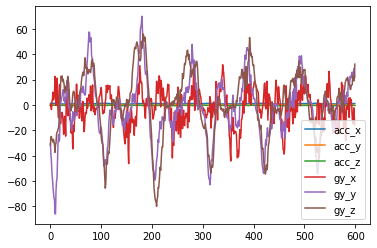

In [7]:
#id 별로 동작들의 흐름 살펴보기
ex=train[train['id']==0]
ex.iloc[:, 2:].plot()


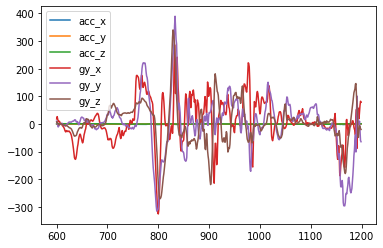

In [8]:
ex = train[train['id']==1]
ex.iloc[:,2 :].plot()

In [9]:
# 데이터 개수 및 shape 분석
print("train 데이터 개수: {}, train 데이터 shape : {}" .format(train['id'].nunique(), train.shape ))
print("train_labels 데이터 개수: {}, train_labels 데이터 shape : {}" .format(train_labels['id'].nunique(), train_labels.shape ))
print("train_labels 최대 값", max(train_labels['label']))
print("test 데이터 개수: {}, test 데이터 shape : {}" .format(test['id'].nunique(), test.shape ))


train 데이터 개수: 3125, train 데이터 shape : (1875000, 8)
train_labels 데이터 개수: 3125, train_labels 데이터 shape : (3125, 3)
train_labels 최대 값 60
test 데이터 개수: 782, test 데이터 shape : (469200, 8)


In [10]:
#텐서플로우, 케라스 라이브러리
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D,Dropout
from keras.callbacks import ModelCheckpoint

In [11]:
train.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234


In [12]:
train_labels.head()

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise


In [13]:
#데이터 수정
X_train= tf.reshape(np.array(train.iloc[:,2:]), [-1, 600, 6])
X_train.shape

TensorShape([3125, 600, 6])

In [14]:
y_train = tf.keras.utils.to_categorical(train_labels['label'])
y_train.shape

(3125, 61)

In [15]:
#모델 생성
model = Sequential()
model.add(Conv1D(128, kernel_size=3,
                         padding="causal",
                         activation="relu",
                         input_shape=[600, 6]))
model.add(LSTM(64, return_sequences=True,))
model.add(LSTM(64, ))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(61, activation='softmax', kernel_initializer='he_normal'))


In [16]:
#모델 compile
optimizer = keras.optimizers.Adam(lr = 0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# ModelCheckPoint
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/dacon-ai-competition/운동동작분류/my_checkpoint.ckpt '
checkpoint = ModelCheckpoint(filepath = checkpoint_path, save_weights_only = True, save_best_only = True, monitor='val_loss', verbose=1)

In [ ]:
#모델 학습
history = model.fit(X_train,y_train, epochs=100, batch_size=128, validation_split=0.2, callbacks=[checkpoint],)
model.load_weights(checkpoint_path)

Epoch 1/100
20/20 [==============================] - 1s 71ms/step - loss: 0.6799 - accuracy: 0.8060 - val_loss: 1.4180 - val_accuracy: 0.6416

Epoch 00001: val_loss did not improve from 1.36123
Epoch 2/100
20/20 [==============================] - 1s 64ms/step - loss: 0.8531 - accuracy: 0.7468 - val_loss: 1.4925 - val_accuracy: 0.6512

Epoch 00002: val_loss did not improve from 1.36123
Epoch 3/100
20/20 [==============================] - 1s 65ms/step - loss: 0.7974 - accuracy: 0.7640 - val_loss: 1.4380 - val_accuracy: 0.6624

Epoch 00003: val_loss did not improve from 1.36123
Epoch 4/100
20/20 [==============================] - 1s 64ms/step - loss: 0.7327 - accuracy: 0.7836 - val_loss: 1.4529 - val_accuracy: 0.6544

Epoch 00004: val_loss did not improve from 1.36123
Epoch 5/100
20/20 [==============================] - 1s 65ms/step - loss: 0.6703 - accuracy: 0.7996 - val_loss: 1.3981 - val_accuracy: 0.6672

Epoch 00005: val_loss did not improve from 1.36123
Epoch 6/100
20/20 [===========

KeyboardInterrupt: ignored

In [ ]:
test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 600, 6])
test_X.shape

TensorShape([782, 600, 6])

In [ ]:
prediction = model.predict(test_X)
prediction.shape

(782, 61)

In [ ]:
submission.iloc[:,1:]=prediction

In [ ]:
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.009051,3.686696e-04,6.308579e-08,1.303189e-06,4.523438e-04,3.134243e-06,1.153427e-04,4.519165e-05,2.107922e-06,5.125218e-02,3.009433e-02,7.715949e-02,2.322742e-05,2.247023e-01,3.733579e-05,0.000232,6.203739e-05,1.267901e-05,4.399270e-10,5.461614e-12,9.329599e-09,3.588287e-06,5.572922e-06,9.090971e-07,2.996424e-01,1.433305e-05,5.219774e-04,5.574458e-06,3.215967e-10,3.596241e-08,3.475228e-02,1.068381e-02,3.234845e-06,6.592089e-04,5.139442e-03,9.372900e-10,1.714312e-05,7.088724e-05,6.025858e-06,9.935148e-08,1.304246e-04,5.856533e-07,5.775013e-07,4.843800e-05,6.402992e-07,5.140138e-04,5.848947e-09,1.697722e-06,5.902160e-06,4.579439e-05,4.929437e-03,3.235279e-06,1.885618e-06,1.401632e-07,9.946849e-04,8.713123e-08,6.970781e-07,0.001242,2.469351e-01,9.161976e-07,2.342787e-06
1,3126,0.000023,7.563322e-06,3.443707e-11,1.475681e-07,3.207154e-05,8.231346e-07,9.819377e-12,2.611673e-05,8.302877e-09,1.471475e-09,1.797280e-07,1.245773e-06,1.764412e-10,7.720347e-06,6.793144e-07,0.000048,3.026503e-07,1.860204e-08,1.985631e-08,3.238853e-12,1.632572e-12,5.525540e-06,4.170127e-04,2.309108e-04,1.201509e-07,7.665960e-08,9.984915e-01,7.633203e-12,3.044338e-09,9.767165e-09,6.055073e-08,2.896780e-07,1.906267e-06,3.144823e-06,1.138916e-07,1.125270e-07,1.323218e-07,2.722875e-09,3.639494e-11,1.739152e-10,1.224834e-06,4.300254e-08,2.806614e-09,9.833256e-10,1.329597e-07,2.083974e-08,9.854502e-08,2.429104e-08,8.454495e-05,1.171327e-04,1.469320e-04,1.311911e-09,6.776052e-10,1.064929e-10,2.601929e-09,8.184396e-11,3.951534e-09,0.000069,1.549508e-08,3.426934e-07,2.820284e-04
2,3127,0.000020,5.211813e-03,2.340455e-06,1.646560e-04,3.731325e-06,1.835513e-05,1.945363e-01,2.845721e-05,4.534802e-06,3.280620e-03,4.236899e-05,7.801673e-04,6.614746e-07,7.605238e-07,6.899458e-08,0.000017,3.547965e-06,6.271872e-07,2.012795e-10,1.742674e-09,7.760976e-08,1.665428e-04,5.430380e-07,2.492005e-08,1.011525e-03,4.827923e-05,6.476915e-07,1.121509e-03,1.401500e-12,2.021934e-06,6.819588e-04,2.748987e-03,4.846952e-07,4.534393e-04,9.979558e-04,7.041605e-10,1.060544e-08,3.627768e-01,5.721502e-05,2.844412e-08,1.126064e-03,2.477752e-05,1.083384e-03,5.133845e-05,9.567354e-06,2.199641e-01,1.788601e-08,2.021894e-01,2.465134e-06,1.896350e-05,1.269622e-05,2.706082e-05,3.974046e-09,2.772740e-06,7.179428e-04,8.239882e-07,4.647524e-04,0.000003,9.336556e-05,2.312232e-05,4.244672e-09
3,3128,0.000148,6.144437e-07,2.140048e-09,2.698433e-07,3.556650e-07,1.347981e-07,3.039213e-10,2.392444e-05,1.909739e-06,8.946257e-08,1.729235e-05,2.103400e-05,1.348903e-06,1.214705e-05,1.570026e-05,0.000111,1.652280e-07,4.118397e-10,3.711449e-09,4.832717e-13,4.670564e-11,8.526855e-06,4.586449e-06,1.084186e-05,3.760711e-05,5.712361e-08,9.948509e-01,6.617581e-10,1.037341e-07,1.558594e-06,3.379237e-08,1.047031e-07,2.403273e-04,1.786827e-06,6.368884e-07,9.104912e-10,4.336524e-06,1.580629e-09,4.517876e-06,3.194003e-07,4.787670e-07,7.114832e-08,8.514669e-09,3.665884e-07,4.973590e-08,1.021037e-05,8.470965e-09,9.740769e-08,2.881058e-04,7.458685e-04,9.024798e-04,1.017176e-06,4.338753e-06,2.074854e-09,2.664772e-06,1.665673e-09,3.980101e-10,0.000164,5.022537e-06,1.136517e-08,2.355737e-03
4,3129,0.000009,8.950723e-08,1.596563e-12,6.656394e-09,2.233307e-05,1.655525e-07,2.863043e-13,6.176320e-08,3.095208e-10,1.595892e-10,1.217794e-07,6.872582e-08,3.612982e-10,2.079029e-08,2.775958e-08,0.000007,4.583911e-08,8.951653e-10,1.999409e-09,3.208421e-12,4.347753e-13,2.876393e-07,6.000968e-06,4.428971e-07,2.216048e-07,4.398469e-08,9.993939e-01,2.560157e-13,2.178611e-10,5.271515e-07,5.677304e-09,8.292252e-09,2.167618e-05,6.716488e-07,3.906837e-08,2.232740e-09,9.287197e-10,5.286638e-11,2.135898e-10,5.644442e-11,1.206561e-07,7.169454e-08,1.027098e-08,4.167332e-09,1.655426e-09,3.420378e-09,1.379469e-07,3.397023e-10,1.692685e-04,2.022583e-04,1.562332e-04,4.054251e

In [ ]:
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/dacon-ai-competition/운동동작분류/open\dacon_submission2.csv', index=False)